In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class GaussianMixtureModel:
    def __init__(self,k_clusters,init_mean,init_covariance,pi=np.zeros(2),iteration=50):
        self.k_clusters=k_clusters
        self.iteration=iteration
        self.mean=init_mean
        self.covariance=init_covariance
        self.pi=pi
        if np.array_equal(self.pi,np.zeros(2)):
            self.pi = [1/self.k_clusters for k in range(self.k_clusters)]        
        else:
            self.pi=pi
            
        
    def fit(self, data):
        
        #initializing responsibility array
        self.r = np.zeros((len(data), self.k_clusters))
        for it in range(self.iteration):
            
            #calculate responsibility
            for i in range(len(data)):
                for k in range(self.k_clusters):
                    self.r[i, k] = self.pi[k]*multivariate_normal.pdf(data[i], mean=self.mean[k], cov=self.covariance[k])
                    
            #normalize responsibility
            row_sum = self.r.sum(axis=1)[:, np.newaxis]
            self.r = self.r / row_sum
            N= np.sum(self.r, axis=0)
            
            #update pi
            self.pi = [N[clust]/len(data) for clust in range(self.k_clusters)]
            
            #update cluster means
            self.mean = [np.zeros(len(data[0]))] * self.k_clusters
            for k in range(self.k_clusters):
                weighted_sum = 0.
                for i in range(len(data)): 
                    weighted_sum += self.r[i][k] * data[i]
                nk_soft = N[k]
                self.mean[k] = (1/nk_soft)*weighted_sum
            
            #update clusters covariance
            self.covariance = [np.zeros((len(data[0]), len(data[0])))] * self.k_clusters
            for k in range(self.k_clusters):
                weighted_sum = np.zeros((len(data[0]), len(data[0])))
                for i in range(len(data)):
                    xi,uk = data[i], self.mean[k]
                    weighted_sum += self.r[i][k]* np.outer(xi-uk,xi-uk)
                nk_soft = N[k]
                self.covariance[k] =(1/nk_soft)*weighted_sum
            
    def predict(self,data):
        #calculating probabilities of data points (soft clustering)
        prob = []
        for i in range(len(data)):
            prob.append([multivariate_normal.pdf(data[i], self.mean[k], self.covariance[k])
                           for k in range(self.k_clusters)])

        #getting cluster of each data point (hard clustering)
        cluster = []
        clusters = np.arange(self.k_clusters)
        for proba in prob:
            cluster.append(clusters[proba.index(max(proba))])
            
        return self.mean,self.pi,self.covariance,self.r,prob,cluster


In [3]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        k = np.random.choice(len(weights), 1, p=weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [4]:

init_means = [
    [5, 0],
    [1, 1], 
    [0, 5]  
]
init_covariances = [
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]] 
]
init_weights = [1/4., 1/2., 1/4.]  

np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)
print(data[:5])

[array([0.31845368, 5.03182099]), array([1.45029339, 2.15717573]), array([1.02645431, 4.76042375]), array([ 5.23493625, -0.81138851]), array([ 4.65710743, -0.08532351])]


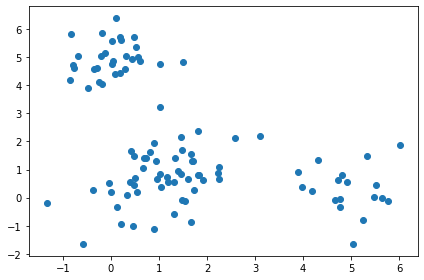

In [5]:
plt.figure()
d = np.vstack(data)
plt.scatter(d[:,0], d[:,1])

plt.tight_layout()

In [6]:
np.random.seed(4)
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

In [7]:
gmm_model=GaussianMixtureModel(3,initial_means,initial_covs)

In [8]:
gmm_model.fit(data)

In [9]:
mean,pi,covariance,responsibility,probabilities,clusters=gmm_model.predict(data)

In [10]:
print('mean= ',mean)
print('--------------------------------------------------------------')
print('pi= ',pi)
print('--------------------------------------------------------------')
print('covariance= ',covariance)
print('--------------------------------------------------------------')
print('responsibility= ',responsibility)
print('--------------------------------------------------------------')
print('probabilities= ',probabilities)
print('--------------------------------------------------------------')
print('clusters= ',clusters)

mean=  [array([0.0213607 , 4.94776653]), array([4.94239198, 0.31365344]), array([1.08181039, 0.7390666 ])]
--------------------------------------------------------------
pi=  [0.3007036502756672, 0.17993715237070484, 0.5193591973536278]
--------------------------------------------------------------
covariance=  [array([[0.29324532, 0.05052346],
       [0.05052346, 0.35275804]]), array([[ 0.35564413, -0.01494922],
       [-0.01494922,  0.66695052]]), array([[0.67114087, 0.33058391],
       [0.33058391, 0.90436499]])]
--------------------------------------------------------------
responsibility=  [[9.99999757e-01 8.58553801e-21 2.42786909e-07]
 [1.85577031e-07 6.43427064e-09 9.99999808e-01]
 [9.99916852e-01 1.21031984e-15 8.31478807e-05]
 [5.80118302e-48 9.99999998e-01 2.43888849e-09]
 [1.36377137e-37 9.99997956e-01 2.04449835e-06]
 [9.99999175e-01 8.38376988e-20 8.24921777e-07]
 [9.99999986e-01 9.99584944e-24 1.39645653e-08]
 [2.68848596e-31 9.99774531e-01 2.25468738e-04]
 [5.47566469e-

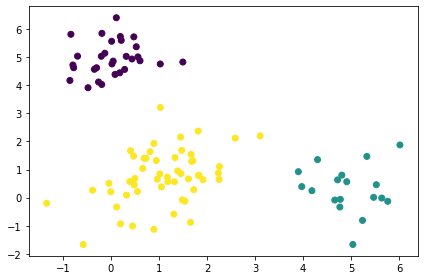

In [11]:
plt.figure()
d = np.vstack(data)
plt.scatter(d[:,0], d[:,1],c=clusters)
plt.tight_layout()